# Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("df_final.csv")
SPY = pd.read_csv("SPY_Train.csv")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df.head(3)

,Date,PERMNO,TICKER,Price,Return,Shares Outstanding,SPY Return,Rf,Var,Cov,Beta,Alpha,Turnover Rank,Dollar Turnover Rank,Current Ratio Rank,Cash Ratio Rank,Quick Ratio Rank,Revenue Growth Rank,COGS Growth Rank,Operating Income Growth Rank,Net Income Growth Rank,EPS Basic Growth Rank,Net Operating Cash Flow Growth Rank
0,1995-02-01,75844,POT,35.125,0.021352,42781,0.024591,0.005875,0.001403,0.000872,0.621788,0.003840,1,1,2,4,3,10,10,10,9,9,4
1,1995-02-01,75615,DFI,8.500,-0.014706,27213,0.024591,0.005875,NaN,NaN,NaN,NaN,6,9,2,2,4,4,4,6,10,10,7
2,1995-02-01,40694,TXI,31.250,0.000000,12406,0.024591,0.005875,0.000723,-0.000774,-1.070816,0.014166,4,3,2,8,3,7,8,5,4,4,2


In [4]:
# df.groupby(by='PERMNO')['Alpha'].fillna(df.groupby(by='PERMNO')['Alpha'].mean(), inplace=True)
# #df.reset_index(inplace=True)
# df.head(3)

In [5]:
# Transform Date into datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:
# Construct Date List
Date = []
for i in range(1995, 2016):
    for j in range(1, 13):
        date = str(i) + '-' + str(j)
        Date.append(date)
        
Date = Date[1:]
# for i in range(1,12):
#     Date.remove("1999-" + str(i))

In [7]:
Factor_List = ['Turnover', 'Dollar Turnover', 'Current Ratio', 'Cash Ratio', 'Quick Ratio',
 'Revenue Growth', 'COGS Growth', 'Operating Income Growth', 'Net Income Growth', 'EPS Basic Growth',
 'Net Operating Cash Flow Growth']

Factor_Rank = ['Turnover Rank', 'Dollar Turnover Rank', 'Current Ratio Rank',
 'Cash Ratio Rank', 'Quick Ratio Rank', 'Revenue Growth Rank',
 'COGS Growth Rank', 'Operating Income Growth Rank', 'Net Income Growth Rank',
 'EPS Basic Growth Rank', 'Net Operating Cash Flow Growth Rank']

# Select Stocks based on Rank

In [8]:
class Solve():
    def __init__(self, df, SPY, Date, Factor_Rank):
        self.df = df
        self.Date = Date
        self.SPY = SPY
        self.Factor_Rank = Factor_Rank
        
    def Combine_Factors(self):
        self.df['Liquid Ratio Rank'] = (self.df['Cash Ratio Rank'] + self.df['Current Ratio Rank'] + self.df['Quick Ratio Rank']) / 3 
        self.df['Turnover Combine Rank'] = (self.df['Turnover Rank'] + self.df['Dollar Turnover Rank']) / 2
        self.df['Liquidity Combine Rank'] = (self.df['Liquid Ratio Rank'] + self.df['Turnover Combine Rank']) / 2
        self.df['Growth Combine Rank'] = (self.df['Net Operating Cash Flow Growth Rank'] + self.df['EPS Basic Growth Rank'] + 
                                            self.df['Revenue Growth Rank'] + self.df['COGS Growth Rank'] + 
                                            self.df['Operating Income Growth Rank'] + self.df['Net Income Growth Rank']) / 6
        
        self.df['Total Rank'] = (self.df['Liquidity Combine Rank'] + self.df['Growth Combine Rank']) / 2 
                              
    def Get_Returns(self):
        self.df_ = self.df.copy()
#         self.df_.dropna(subset=['Alpha'], inplace=True)
#         self.df_.reset_index(inplace=True)
        self.Returns1 = {} # Used to store TOP each factor's return for each month
        self.Returns2 = {} # Used to store BOT each factor's return for each month
        self.Excesses1 = {} # Used to store TOP each factor's excess return for each month
        self.Excesses2 = {} # Used to store BOT each factor's excess return for each month
        self.Diffs = {} # Used to store each factor's diff return for each month
        self.Diffs_Excess = {} # Used to store each factor's diff excess return for each month
        
        self.Alpha1 = {}  # TOP Alpha
        self.Alpha2 = {}  # BOT Alpha
        self.Alpha3 = {}  # DIF Alpha
        
        
        for factor in self.Factor_Rank:
            Return1 = []  # Used to store TOP return for each month
            Return2 = []  # Used to store BOT return for each month
            Excess1 = []  # Used to store TOP excess return for each month
            Excess2 = []  # Used to store BOT excess return for each month
            Diff = []    # Used to store return of difference between TOP and BOT for each month
            Diff_Excess = []    # Used to store excess return of difference between TOP and BOT for each month
            
            Alpha1 = []  # TOP Alpha
            Alpha2 = []  # BOT Alpha
            Alpha3 = []  # DIF Alpha
            
            for date in Date:
                DF = self.df_[date].copy()  # Divide the big df into small DF by date
                N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
                DF = DF.sort_values(by = [factor], axis = 0, ascending = True)  # Sort by Turnover
                #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
                profit1 = DF.iloc[:N]['Return'].mean()
                profit2 = DF.iloc[-N:]['Return'].mean()
                diff = profit1 - profit2
                profit_SPY = DF.iloc[:N]['SPY Return'].mean()
                
                alpha1 = DF.iloc[:N]['Alpha'].mean()
                alpha2 = DF.iloc[-N:]['Alpha'].mean()
                alpha3 = alpha1 - alpha2

                Return1.append( profit1 )
                Return2.append( profit2 )
                Excess1.append( profit1 - profit_SPY )
                Excess2.append( profit2 - profit_SPY )
                Diff.append( diff )
                Diff_Excess.append( diff - profit_SPY )
                
                Alpha1.append(alpha1)
                Alpha2.append(alpha2)
                Alpha3.append(alpha3)

            self.Returns1[factor] = Return1 
            self.Returns2[factor] = Return2 
            self.Excesses1[factor] = Excess1
            self.Excesses2[factor] = Excess2
            self.Diffs[factor] = Diff
            self.Diffs_Excess[factor] = Diff_Excess
            
            self.Alpha1[factor] = Alpha1
            self.Alpha2[factor] = Alpha2
            self.Alpha3[factor] = Alpha3

    def Return_Summary(self):
        print("Summary for SPY Return:"); print(self.df['SPY Return'].describe())
        print("=============++++++++++++++=============")
        
        for key in self.Factor_Rank:
            print("=================" + key + "=================")
            print("Summary for TOP Return:"); print(pd.Series(self.Returns1[key]).describe(), "\n")
            print("Summary for BOT Return:"); print(pd.Series(self.Returns2[key]).describe(), "\n")
            print("Summary for Diff Return:"); print(pd.Series(self.Diffs[key]).describe(), "\n")
            print("Summary for TOP Excess Return:"); print(pd.Series(self.Excesses1[key]).describe(), "\n")
            print("Summary for BOT Excess Return:"); print(pd.Series(self.Excesses2[key]).describe(), "\n")
            print("Summary for Diff Excess Return:"); print(pd.Series(self.Diffs_Excess[key]).describe())
            print("=================++++++++++++++=================")
        
    def T_Test_Return(self):
        from scipy import stats
        print("==============================T Test For Return==============================")
        for factor in self.Factor_Rank:
            print("Result of T Test for " + factor + "(TOP):")
            print(stats.ttest_1samp(self.Returns1[factor], 0))
            print("Result of T Test for " + factor + "(BOT):")
            print(stats.ttest_1samp(self.Returns2[factor], 0))
            print("Result of T Test for " + factor + "(Diff):")
            print(stats.ttest_1samp(self.Diffs[factor], 0))
            print("==============================++++++++++++++==============================")
            
    def T_Test_Excess(self):
        from scipy import stats
        print("==============================T Test For Excess Return==============================")
        for factor in self.Factor_Rank:
            print("Result of T Test for " + factor + "(TOP):")
            print(stats.ttest_1samp(self.Excesses1[factor], 0))
            print("Result of T Test for " + factor + "(BOT):")
            print(stats.ttest_1samp(self.Excesses2[factor], 0))
            print("Result of T Test for " + factor + "(Diff Excess):")
            print(stats.ttest_1samp(self.Diffs_Excess[factor], 0))
            print("==============================++++++++++++++==============================")
            
            
    def Alpha_Summary(self, Factors):
        from scipy import stats     
        
        for key in Factors:
            a = []
            b = []
            c = []
            
            for i in range(251):
                if np.isnan(self.Alpha1[key][i]) == False:
                    a.append(self.Alpha1[key][i])
                if np.isnan(self.Alpha2[key][i]) == False:
                    b.append(self.Alpha2[key][i])
                if np.isnan(self.Alpha3[key][i]) == False:
                    c.append(self.Alpha3[key][i])
                 
            print("============================" + key + "============================")
            print("Mean of " + key + "'s Alpha (TOP): ", np.mean(a))
            print("Result of T Test for " + key + "'s Alpha is(TOP): ")
            print(stats.ttest_1samp(a, 0), "\n")
            
            print("Mean of " + key + "'s Alpha (BOT): ", np.mean(b))
            print("Result of T Test for " + key + "'s Alpha is(BOT): ")
            print(stats.ttest_1samp(b, 0), "\n")
            
            print("Mean of " + key + "'s Alpha (DIF): ", np.mean(c))
            print("Result of T Test for " + key + "'s Alpha is(DIF): ")
            print(stats.ttest_1samp(c, 0), "\n")       
        
        print("============================++++++++++++++============================")
            
    def Plot_hist_Return(self):
        plt.figure(figsize=(15,3))
        count = 0
        
        for key in self.Factor_Rank:
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Returns1[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of TOP Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Excesses1[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of TOP Excess Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Returns2[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of BOT Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Excesses2[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of BOT Excess Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Diffs[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of Diff Return from' + key)
            
            count += 1
            ax = plt.subplot(13,6,count)
            plt.hist(self.Diffs_Excess[key], bins=20)
            plt.ylabel('Frequency')
            plt.title('Distribution of Diff Excess Return from' + key)


    def Plot_Cum_TOP_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Returns1[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor (TOP)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 0.9, len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_TOP_Excess(self):

        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Excesses1[factor])+1).cumprod()-1, label = factor) 
 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor (TOP)',fontsize =15)

        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 0.9, len(ax1.lines))]

        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_BOT_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Returns2[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 0.9, len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_BOT_Excess(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Excesses2[factor])+1).cumprod()-1, label = factor) 
 
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor (BOT)',fontsize =15)

        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 0.9, len(ax1.lines))]

        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_Diff_Return(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Diffs[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 0.9, len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)
        
    def Plot_Cum_Diff_Excess(self):
        fig1 = plt.figure(figsize = (20, 10))
        ax1 = fig1.add_subplot(111)
        
        #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
        for factor in self.Factor_Rank:
            plt.plot(self.Date, (pd.Series(self.Diffs_Excess[factor])+1).cumprod()-1, label = factor) 
            
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
        plt.xticks(np.arange(0, len(Date), step=12))
        plt.ylabel('Cumulative Return', fontsize = 15)
        locs, labels = plt.xticks() 
        plt.setp(labels, rotation = 90)
        plt.title('Cumulative Excess Returns for each Factor (BOT)',fontsize =15)
        
        colormap = plt.cm.gist_ncar
        colors = [colormap(i) for i in np.linspace(0, 0.9, len(ax1.lines))]
        
        for i,j in enumerate(ax1.lines):
            j.set_color(colors[i])
        ax1.legend(loc=2)

In [9]:
Object = Solve(df, SPY, Date, Factor_Rank)

## Calculate Returns and Excess Returns

In [10]:
Object.Get_Returns()

## Give a Summary for all Factors' Return and Excess

In [11]:
Object.Return_Summary()

Summary for SPY Return:
count    285093.000000
mean          0.007020
std           0.046188
min          -0.167743
25%          -0.019145
50%           0.013041
75%           0.034470
max           0.157330
Name: SPY Return, dtype: float64
=============++++++++++++++=============
=================Turnover Rank=================
Summary for TOP Return:
count    251.000000
mean       0.013364
std        0.070067
min       -0.259667
25%       -0.032988
50%        0.012670
75%        0.061013
max        0.250835
dtype: float64 

Summary for BOT Return:
count    251.000000
mean       0.010904
std        0.042457
min       -0.178939
25%       -0.010526
50%        0.014535
75%        0.037611
max        0.141314
dtype: float64 

Summary for Diff Return:
count    251.000000
mean       0.002460
std        0.039945
min       -0.125318
25%       -0.024839
50%        0.001124
75%        0.029007
max        0.133749
dtype: float64 

Summary for TOP Excess Return:
count    251.000000
mean       0.00

count    251.000000
mean       0.005945
std        0.063802
min       -0.206331
25%       -0.036991
50%        0.004642
75%        0.040281
max        0.244357
dtype: float64 

Summary for BOT Excess Return:
count    251.000000
mean       0.003731
std        0.065827
min       -0.214441
25%       -0.037892
50%        0.003514
75%        0.039464
max        0.259167
dtype: float64 

Summary for Diff Excess Return:
count    251.000000
mean      -0.004969
std        0.050716
min       -0.175188
25%       -0.031989
50%       -0.010475
75%        0.022953
max        0.211822
dtype: float64
=================++++++++++++++=================


In [12]:
Object.T_Test_Return()

==============================T Test For Return==============================
Result of T Test for Turnover Rank(TOP):
Ttest_1sampResult(statistic=3.0217716353562336, pvalue=0.002774032152273343)
Result of T Test for Turnover Rank(BOT):
Ttest_1sampResult(statistic=4.068707805399651, pvalue=6.342661553067133e-05)
Result of T Test for Turnover Rank(Diff):
Ttest_1sampResult(statistic=0.9758201069612912, pvalue=0.33009689548317445)
==============================++++++++++++++==============================
Result of T Test for Dollar Turnover Rank(TOP):
Ttest_1sampResult(statistic=3.054204171053089, pvalue=0.0025006705156353573)
Result of T Test for Dollar Turnover Rank(BOT):
Ttest_1sampResult(statistic=3.797637619982264, pvalue=0.00018344238701950493)
Result of T Test for Dollar Turnover Rank(Diff):
Ttest_1sampResult(statistic=-0.6197878974486943, pvalue=0.5359619125204225)
==============================++++++++++++++==============================
Result of T Test for Current Ratio Rank(TO

In [13]:
Object.T_Test_Excess()

==============================T Test For Excess Return==============================
Result of T Test for Turnover Rank(TOP):
Ttest_1sampResult(statistic=1.2148076503205445, pvalue=0.2255855855487957)
Result of T Test for Turnover Rank(BOT):
Ttest_1sampResult(statistic=1.0635318165500351, pvalue=0.2885670349678291)
Result of T Test for Turnover Rank(Diff Excess):
Ttest_1sampResult(statistic=-1.1687346550462503, pvalue=0.24362377944769972)
==============================++++++++++++++==============================
Result of T Test for Dollar Turnover Rank(TOP):
Ttest_1sampResult(statistic=0.8514267982868859, pvalue=0.3953471221660291)
Result of T Test for Dollar Turnover Rank(BOT):
Ttest_1sampResult(statistic=1.31074082271631, pvalue=0.1911481340974718)
Result of T Test for Dollar Turnover Rank(Diff Excess):
Ttest_1sampResult(statistic=-2.189058658806919, pvalue=0.029517734221277167)
==============================++++++++++++++==============================
Result of T Test for Current R

In [14]:
Object.Alpha_Summary(Factor_Rank)

============================Turnover Rank============================
Mean of Turnover Rank's Alpha (TOP):  0.010697756948803755
Result of T Test for Turnover Rank's Alpha is(TOP): 
Ttest_1sampResult(statistic=2.4371277929622086, pvalue=0.015557290478839596) 

Mean of Turnover Rank's Alpha (BOT):  0.009686064986259367
Result of T Test for Turnover Rank's Alpha is(BOT): 
Ttest_1sampResult(statistic=3.8457572725023836, pvalue=0.00015418174659333973) 

Mean of Turnover Rank's Alpha (DIF):  0.001083462753872791
Result of T Test for Turnover Rank's Alpha is(DIF): 
Ttest_1sampResult(statistic=0.41376176058192593, pvalue=0.679430823386055) 

============================Dollar Turnover Rank============================
Mean of Dollar Turnover Rank's Alpha (TOP):  0.008921233306773007
Result of T Test for Dollar Turnover Rank's Alpha is(TOP): 
Ttest_1sampResult(statistic=2.4685047980995027, pvalue=0.014277756757868472) 

Mean of Dollar Turnover Rank's Alpha (BOT):  0.010787109722711831
Result of

## Plot Cumulative Return for each Factor

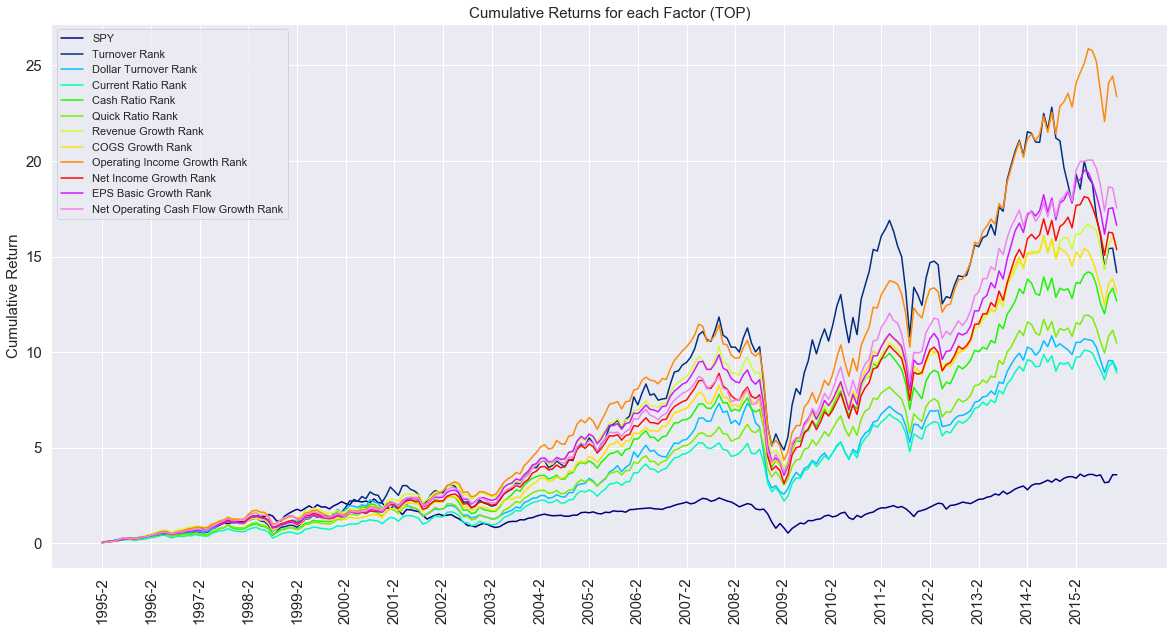

In [15]:
Object.Plot_Cum_TOP_Return()

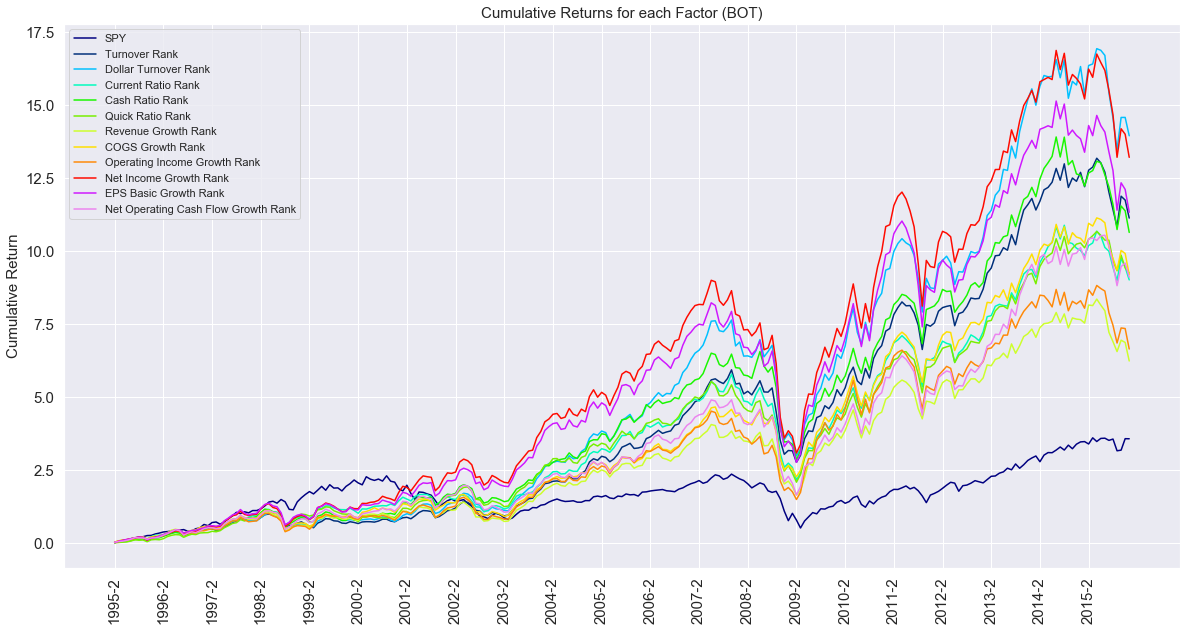

In [16]:
Object.Plot_Cum_BOT_Return()

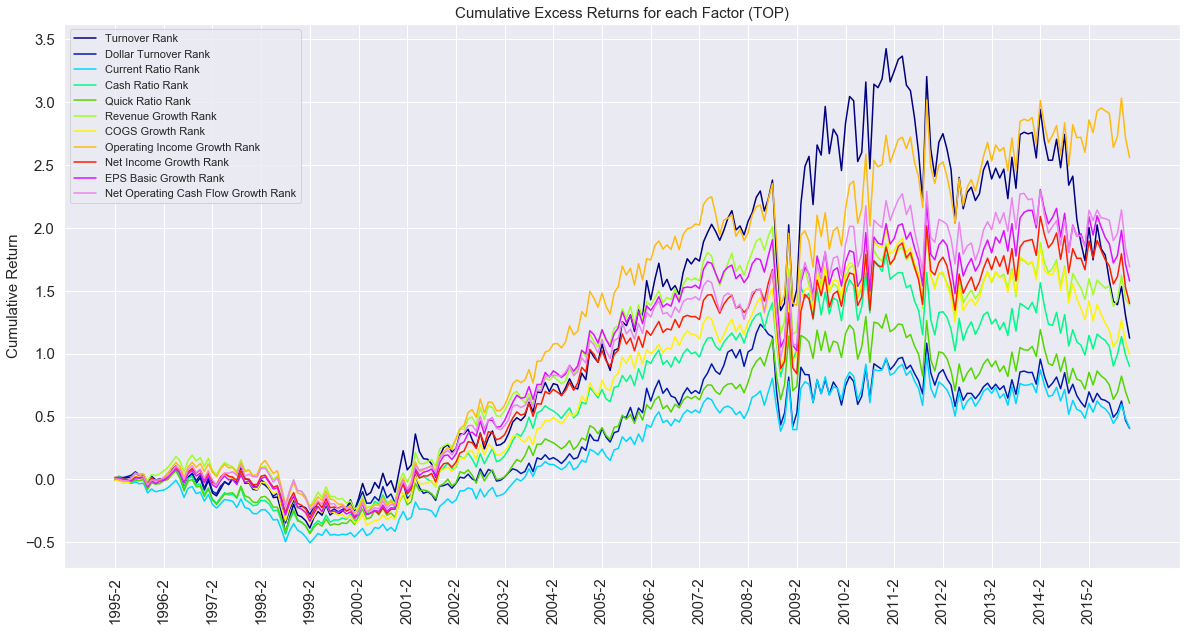

In [17]:
Object.Plot_Cum_TOP_Excess()

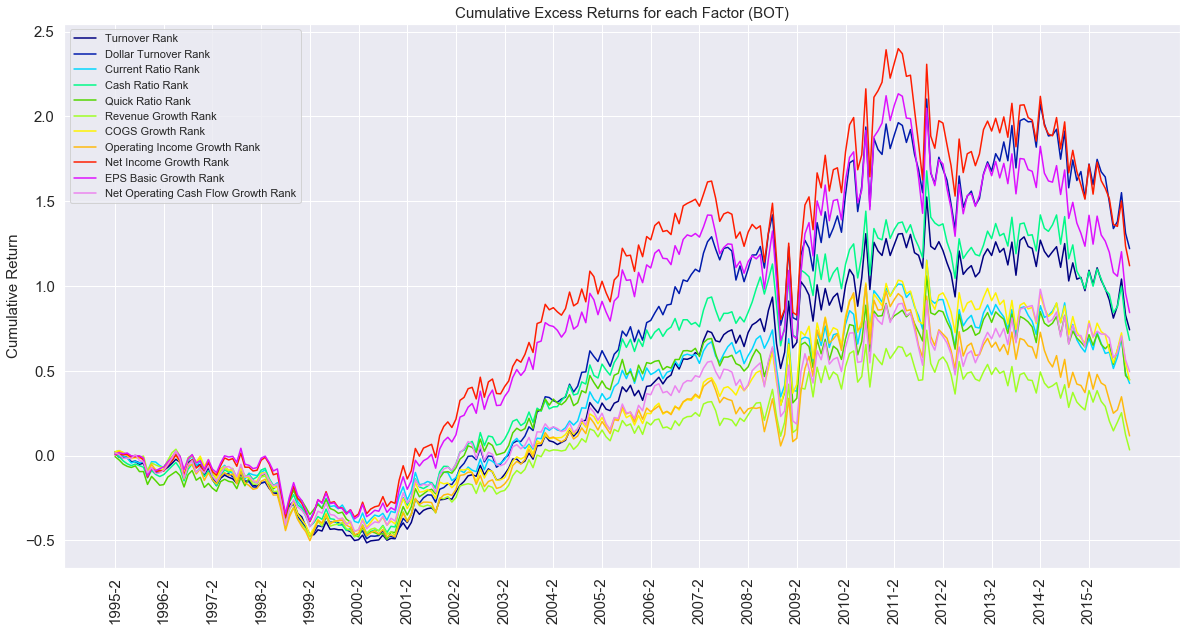

In [18]:
Object.Plot_Cum_BOT_Excess()

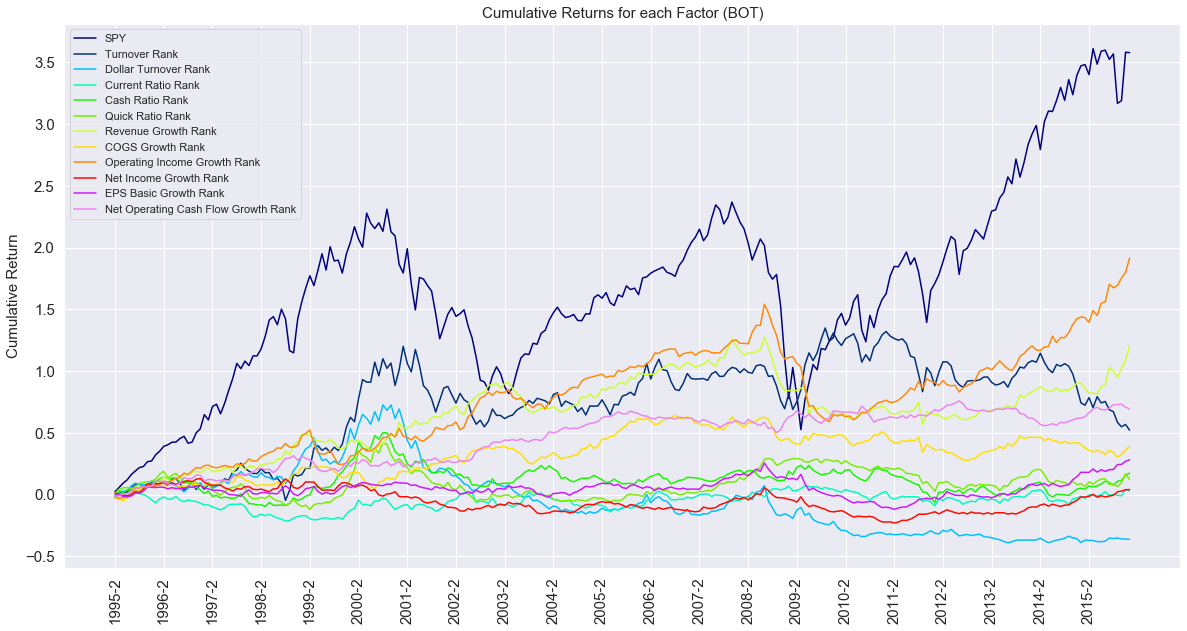

In [19]:
Object.Plot_Cum_Diff_Return()

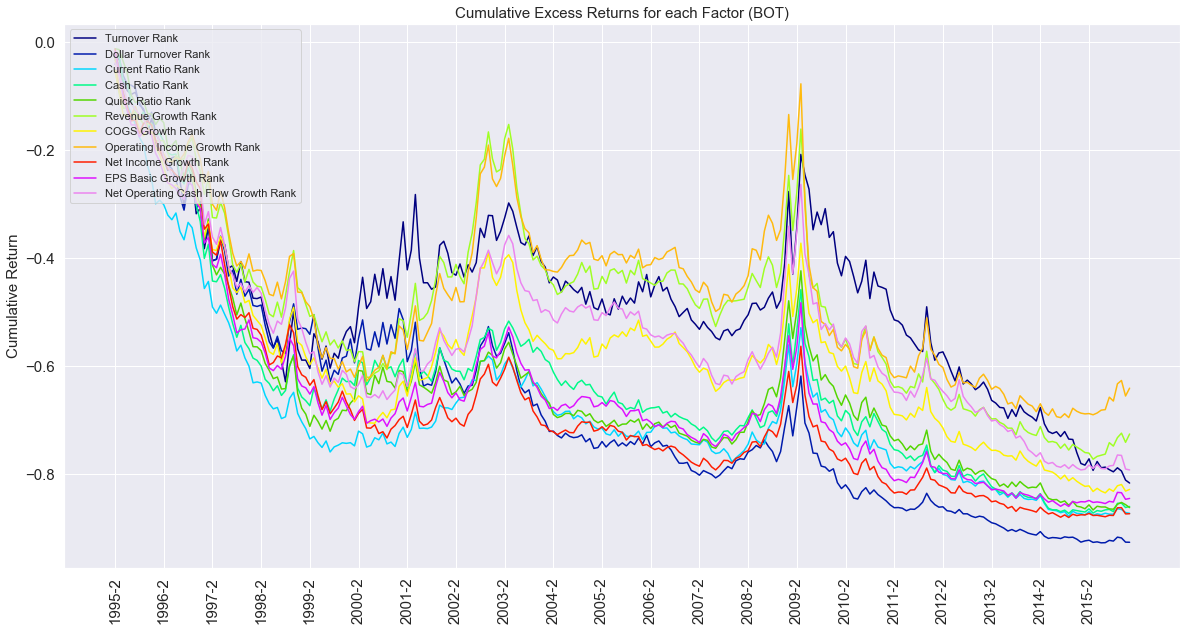

In [20]:
Object.Plot_Cum_Diff_Excess()

# Combine Factors

In [21]:
# class Combine():
#     def __init__(self, df, SPY, Date):
#         self.df = df
#         self.SPY = SPY
#         self.Date = Date
        
#     def Combine_Factors(self):
#         self.data = self.df.copy()
#         self.data['Liquid Ratio Rank'] = (self.data['Cash Ratio Rank'] + self.data['Current Ratio Rank'] + self.data['Quick Ratio Rank']) / 3 
#         self.data['Turnover Combine Rank'] = (self.data['Turnover Rank'] + self.data['Dollar Turnover Rank']) / 2
#         self.data['Income Combine Rank'] = (self.data['COGS Growth Rank'] + self.data['Operating Income Growth Rank'] + self.data['Net Income Growth Rank']) / 3
        
#         self.data['Total Rank'] = (self.data['Revenue Growth Rank'] + self.data['Income Combine Rank'] +
#                                    self.data['EPS Basic Growth Rank'] + self.data['Net Operating Cash Flow Growth Rank'] + self.data['Liquid Ratio Rank'] +
#                                    self.data['Income Combine Rank']) / 6
               
#     def Get_Returns(self):
#         self.data_ = self.data.copy()
           
#         self.Return1 = []  # Used to store TOP return for each month
#         self.Excess1 = []  # Used to store TOP excess return for each month
#         self.Return2 = []  # Used to store BOT return for each month
#         self.Excess2 = []  # Used to store BOT excess return for each month
#         self.Diff = []  # Used to store diff return for each month
#         self.Diff_Excess = []  # Used to store diff excess return for each month
#         for date in Date:
#             DF = self.data_[date].copy()  # Divide the big df into small DF by date
#             N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
#             DF = DF.sort_values(by = ['Total Rank'], axis = 0, ascending = True)  # Sort by Turnover
#             #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
#             profit1 = DF.iloc[N]['Return'].mean()
#             profit2 = DF.iloc[-N:]['Return'].mean()
#             profit_SPY = self.SPY[date]['Return'].values[0]
#             diff = profit1 - profit2

#             self.Return1.append( profit1 )
#             self.Excess1.append( profit1 - profit_SPY )
#             self.Return2.append( profit2 )
#             self.Excess2.append( profit2 - profit_SPY )
#             self.Diff.append( diff )
#             self.Diff_Excess.append( diff - profit_SPY )

#     def Return_Summary(self):
#         print("=============++++++++++++++=============")
#         print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Return(TOP):")
#         print(pd.Series(self.Return1).describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Excess Return(TOP):")
#         print(pd.Series(self.Excess1).describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Return(BOT):")
#         print(pd.Series(self.Return2).describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Excess Return(BOT):")
#         print(pd.Series(self.Excess2).describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Return(Diff):")
#         print(pd.Series(self.Diff).describe())
#         print("=============++++++++++++++=============")
#         print("Summary for Excess Return(Diff):")
#         print(pd.Series(self.Diff_Excess).describe())
#         print("=============++++++++++++++=============")
        
#     def T_Test(self):
#         from scipy import stats
#         print("==============================++++++++++++++==============================")
#         print("Result of T Test (TOP)")
#         print(stats.ttest_1samp(self.Excess1, 0))
#         print("Result of T Test (BOT)")
#         print(stats.ttest_1samp(self.Excess2, 0))
#         print("Result of T Test (Diff)")
#         print(stats.ttest_1samp(self.Diff, 0))
#         print("Result of T Test (Diff Excess)")
#         print(stats.ttest_1samp(self.Diff_Excess, 0))
#         print("==============================++++++++++++++==============================")
            
#     def Plot_hist_Return(self):
#         plt.figure(figsize=(30,4))
        
#         ax1 = plt.subplot(1,7,1)
#         plt.hist(self.SPY['Return'].values, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of SPY Return') 
        
#         ax2 = plt.subplot(1,7,2)
#         plt.hist(self.Return1, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of TOP Return')
            
#         ax3 = plt.subplot(1,7,3)
#         plt.hist(self.Excess1, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of TOP Excess Return') 
        
#         ax4 = plt.subplot(1,7,4)
#         plt.hist(self.Return2, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of BOT Return')
            
#         ax5 = plt.subplot(1,7,5)
#         plt.hist(self.Excess2, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of BOT Excess Return') 
        
#         ax6 = plt.subplot(1,7,6)
#         plt.hist(self.Diff, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of Diff Return')
            
#         ax7 = plt.subplot(1,7,7)
#         plt.hist(self.Diff_Excess, bins=20)
#         plt.ylabel('Frequency')
#         plt.title('Distribution of Diff Excess Return') 

#     def Plot_Cum_Return(self):
#         fig1 = plt.figure(figsize = (15, 6))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY Return')
        
#         plt.plot(self.Date, (pd.Series(self.Return1)+1).cumprod()-1, label = 'TOP Return')   
#         #plt.plot(self.Date, (pd.Series(self.Excess1)+1).cumprod()-1, label = 'TOP Excess Return') 
#         plt.plot(self.Date, (pd.Series(self.Return2)+1).cumprod()-1, label = 'BOT Return')   
#         #plt.plot(self.Date, (pd.Series(self.Excess2)+1).cumprod()-1, label = 'BOT Excess Return')
#         plt.plot(self.Date, (pd.Series(self.Diff)+1).cumprod()-1, label = 'Diff Return')   
#         #plt.plot(self.Date, (pd.Series(self.Diff_Excess)+1).cumprod()-1, label = 'Diff Excess Return') 
        
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Return for Combine Factor',fontsize =15)
        
#         ax1.legend(loc=2)
        
#     def Plot_Cum_Excess(self):
#         fig1 = plt.figure(figsize = (15, 6))
#         ax1 = fig1.add_subplot(111)
        
#         #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY Return')
        
#         #plt.plot(self.Date, (pd.Series(self.Return1)+1).cumprod()-1, label = 'TOP Return')   
#         plt.plot(self.Date, (pd.Series(self.Excess1)+1).cumprod()-1, label = 'TOP Excess Return') 
#         #plt.plot(self.Date, (pd.Series(self.Return2)+1).cumprod()-1, label = 'BOT Return')   
#         plt.plot(self.Date, (pd.Series(self.Excess2)+1).cumprod()-1, label = 'BOT Excess Return')
#         #plt.plot(self.Date, (pd.Series(self.Diff)+1).cumprod()-1, label = 'Diff Return')   
#         plt.plot(self.Date, (pd.Series(self.Diff_Excess)+1).cumprod()-1, label = 'Diff Excess Return') 
        
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Excess Return for Combine Factor',fontsize =15)
        
#         ax1.legend(loc=2)

In [22]:
# class Combine():
#     def __init__(self, df, SPY, Date):
#         self.df = df
#         self.SPY = SPY
#         self.Date = Date
#         self.Factor_Rank = ['Liquidity Combine Rank', 'Growth Combine Rank', 'Total Rank']
        
#     def Combine_Factors(self):
#         self.data = self.df.copy()
#         self.data['Liquid Ratio Rank'] = (self.data['Cash Ratio Rank'] + self.data['Current Ratio Rank'] + self.data['Quick Ratio Rank']) / 3 
#         self.data['Turnover Combine Rank'] = (self.data['Turnover Rank'] + self.data['Dollar Turnover Rank']) / 2
#         self.data['Liquidity Combine Rank'] = (self.data['Liquid Ratio Rank'] + self.data['Turnover Combine Rank']) / 2
#         self.data['Growth Combine Rank'] = (self.data['Net Operating Cash Flow Growth Rank'] + self.data['EPS Basic Growth Rank'] + 
#                                             self.data['Revenue Growth Rank'] + self.data['COGS Growth Rank'] + 
#                                             self.data['Operating Income Growth Rank'] + self.data['Net Income Growth Rank']) / 6
        
#         self.data['Total Rank'] = (self.data['Liquidity Combine Rank'] + self.data['Growth Combine Rank']) / 2 
               
#     def Get_Returns(self):
#         self.data_ = self.data.copy()
           
#         self.Returns1 = {} # Used to store TOP each factor's return for each month
#         self.Returns2 = {} # Used to store BOT each factor's return for each month
#         self.Excesses1 = {} # Used to store TOP each factor's excess return for each month
#         self.Excesses2 = {} # Used to store BOT each factor's excess return for each month
#         self.Diffs = {} # Used to store each factor's diff return for each month
#         self.Diffs_Excess = {} # Used to store each factor's diff excess return for each month
           
#         for factor in self.Factor_Rank:
#             Return1 = []  # Used to store TOP return for each month
#             Return2 = []  # Used to store BOT return for each month
#             Excess1 = []  # Used to store TOP excess return for each month
#             Excess2 = []  # Used to store BOT excess return for each month
#             Diff = []    # Used to store return of difference between TOP and BOT for each month
#             Diff_Excess = []    # Used to store excess return of difference between TOP and BOT for each month
            
#             for date in Date:
#                 DF = self.data_[date].copy()  # Divide the big df into small DF by date
#                 N = int(len(DF)/10)   # We decide to long top 10% of universe and short bottom 10%
#                 DF = DF.sort_values(by = [factor], axis = 0, ascending = True)  # Sort by Turnover
#                 #profit = ( DF.iloc[:N]['Return'].mean() - DF.iloc[-N:]['Return'].mean() ) / 2 
#                 profit1 = DF.iloc[:N]['Return'].mean()
#                 profit2 = DF.iloc[-N:]['Return'].mean()
#                 profit_SPY = self.SPY[date]['Return'].values[0]
#                 diff = profit1 - profit2

#                 Return1.append( profit1 )
#                 Return2.append( profit2 )
#                 Excess1.append( profit1 - profit_SPY )
#                 Excess2.append( profit2 - profit_SPY )
#                 Diff.append( diff )
#                 Diff_Excess.append( diff - profit_SPY )
                
#             self.Returns1[factor] = Return1 
#             self.Returns2[factor] = Return2 
#             self.Excesses1[factor] = Excess1
#             self.Excesses2[factor] = Excess2
#             self.Diffs[factor] = Diff
#             self.Diffs_Excess[factor] = Diff_Excess

#     def Return_Summary(self):
#         print("Summary for SPY Return:"); print(self.SPY['Return'].describe())
#         print("=============++++++++++++++=============")
        
#         for key in self.Factor_Rank:
#             print("=================" + key + "=================")
#             print("Summary for TOP Return:"); print(pd.Series(self.Returns1[key]).describe(), "\n")
#             print("Summary for BOT Return:"); print(pd.Series(self.Returns2[key]).describe(), "\n")
#             print("Summary for Diff Return:"); print(pd.Series(self.Diffs[key]).describe(), "\n")
#             print("Summary for TOP Excess Return:"); print(pd.Series(self.Excesses1[key]).describe(), "\n")
#             print("Summary for BOT Excess Return:"); print(pd.Series(self.Excesses2[key]).describe(), "\n")
#             print("Summary for Diff Excess Return:"); print(pd.Series(self.Diffs_Excess[key]).describe())
#             print("=================++++++++++++++=================")
        
#     def T_Test(self):
#         from scipy import stats
#         print("==============================T Test For Return==============================")
#         for factor in self.Factor_Rank:
#             print("Result of T Test for " + factor + "(TOP):")
#             print(stats.ttest_1samp(self.Returns1[factor], 0))
#             print("Result of T Test for " + factor + "(BOT):")
#             print(stats.ttest_1samp(self.Returns2[factor], 0))
#             print("Result of T Test for " + factor + "(Diff):")
#             print(stats.ttest_1samp(self.Diffs[factor], 0))
#             print("==============================++++++++++++++==============================")
            
#     def T_Test_Excess(self):
#         from scipy import stats
#         print("==============================T Test For Excess Return==============================")
#         for factor in self.Factor_Rank:
#             print("Result of T Test for " + factor + "(TOP):")
#             print(stats.ttest_1samp(self.Excesses1[factor], 0))
#             print("Result of T Test for " + factor + "(BOT):")
#             print(stats.ttest_1samp(self.Excesses2[factor], 0))
#             print("Result of T Test for " + factor + "(Diff Excess):")
#             print(stats.ttest_1samp(self.Diffs_Excess[factor], 0))
#             print("==============================++++++++++++++==============================")
            
#     def Plot_hist_Return(self):
#         plt.figure(figsize=(15,3))
#         count = 0
        
#         N = len(self.Factor_Rank)
#         for key in self.Factor_Rank:
#             count += 1
#             ax = plt.subplot(N,6,count)
#             plt.hist(self.Returns1[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of TOP Return from' + key)
            
#             count += 1
#             ax = plt.subplot(N,6,count)
#             plt.hist(self.Excesses1[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of TOP Excess Return from' + key)
            
#             count += 1
#             ax = plt.subplot(N,6,count)
#             plt.hist(self.Returns2[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of BOT Return from' + key)
            
#             count += 1
#             ax = plt.subplot(N,6,count)
#             plt.hist(self.Excesses2[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of BOT Excess Return from' + key)
            
#             count += 1
#             ax = plt.subplot(N,6,count)
#             plt.hist(self.Diffs[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of Diff Return from' + key)
            
#             count += 1
#             ax = plt.subplot(N,6,count)
#             plt.hist(self.Diffs_Excess[key], bins=20)
#             plt.ylabel('Frequency')
#             plt.title('Distribution of Diff Excess Return from' + key)

#     def Plot_Cum_TOP_Return(self):
#         fig1 = plt.figure(figsize = (20, 10))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Returns1[factor])+1).cumprod()-1, label = factor) 
            
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Returns for each Factor (TOP)',fontsize =15)
        
# #         colormap = plt.cm.gist_ncar
# #         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
# #         for i,j in enumerate(ax1.lines):
# #             j.set_color(colors[i])
#         ax1.legend(loc=2)
        
#     def Plot_Cum_TOP_Excess(self):

#         fig1 = plt.figure(figsize = (20, 10))
#         ax1 = fig1.add_subplot(111)
        
#         #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Excesses1[factor])+1).cumprod()-1, label = factor) 
 
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Excess Returns for each Factor (TOP)',fontsize =15)

# #         colormap = plt.cm.gist_ncar
# #         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

# #         for i,j in enumerate(ax1.lines):
# #             j.set_color(colors[i])
#         ax1.legend(loc=2)
        
#     def Plot_Cum_BOT_Return(self):
#         fig1 = plt.figure(figsize = (20, 10))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Returns2[factor])+1).cumprod()-1, label = factor) 
            
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
# #         colormap = plt.cm.gist_ncar
# #         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
# #         for i,j in enumerate(ax1.lines):
# #             j.set_color(colors[i])
#         ax1.legend(loc=2)
        
#     def Plot_Cum_BOT_Excess(self):

#         fig1 = plt.figure(figsize = (20, 10))
#         ax1 = fig1.add_subplot(111)
        
#         #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black') 

#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Excesses2[factor])+1).cumprod()-1, label = factor) 
 
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Excess Returns for each Factor (BOT)',fontsize =15)

# #         colormap = plt.cm.gist_ncar
# #         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]

# #         for i,j in enumerate(ax1.lines):
# #             j.set_color(colors[i])
#         ax1.legend(loc=2)
        
#     def Plot_Cum_Diff_Return(self):
#         fig1 = plt.figure(figsize = (20, 10))
#         ax1 = fig1.add_subplot(111)
        
#         plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Diffs[factor])+1).cumprod()-1, label = factor) 
            
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
# #         colormap = plt.cm.gist_ncar
# #         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
# #         for i,j in enumerate(ax1.lines):
# #             j.set_color(colors[i])
#         ax1.legend(loc=2)
        
#     def Plot_Cum_Diff_Excess(self):
#         fig1 = plt.figure(figsize = (20, 10))
#         ax1 = fig1.add_subplot(111)
        
#         #plt.plot(self.Date, (self.SPY['Return'].iloc[1:] + 1).cumprod()-1, label = 'SPY', color = 'black')
        
#         for factor in self.Factor_Rank:
#             plt.plot(self.Date, (pd.Series(self.Diffs_Excess[factor])+1).cumprod()-1, label = factor) 
            
#         plt.tick_params(axis='x', which='major', labelsize=15)
#         plt.tick_params(axis='y', which='major', labelsize=15)
#         plt.xticks(np.arange(0, len(Date), step=12))
#         plt.ylabel('Cumulative Return', fontsize = 15)
#         locs, labels = plt.xticks() 
#         plt.setp(labels, rotation = 90)
#         plt.title('Cumulative Returns for each Factor (BOT)',fontsize =15)
        
# #         colormap = plt.cm.gist_ncar
# #         colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
        
# #         for i,j in enumerate(ax1.lines):
# #             j.set_color(colors[i])
#         ax1.legend(loc=2)

In [23]:
Combine_Rank = ['Liquidity Combine Rank', 'Growth Combine Rank', 'Total Rank']
Object2 = Solve(df, SPY, Date, Combine_Rank)

In [24]:
#Object2 = Combine(df, SPY, Date)

## Combine All these Factors into one

In [25]:
Object2.Combine_Factors()

## Calculate Return

In [26]:
Object2.Get_Returns()

## Give a Summary for Return and T Test for Excess Return

In [27]:
Object2.Return_Summary()

Summary for SPY Return:
count    285093.000000
mean          0.007020
std           0.046188
min          -0.167743
25%          -0.019145
50%           0.013041
75%           0.034470
max           0.157330
Name: SPY Return, dtype: float64
=============++++++++++++++=============
=================Liquidity Combine Rank=================
Summary for TOP Return:
count    251.000000
mean       0.011799
std        0.061249
min       -0.238903
25%       -0.024287
50%        0.015358
75%        0.056639
max        0.192665
dtype: float64 

Summary for BOT Return:
count    251.000000
mean       0.010938
std        0.042111
min       -0.163628
25%       -0.011865
50%        0.014874
75%        0.035723
max        0.173061
dtype: float64 

Summary for Diff Return:
count    251.000000
mean       0.000861
std        0.035168
min       -0.124116
25%       -0.020545
50%        0.000230
75%        0.022471
max        0.146491
dtype: float64 

Summary for TOP Excess Return:
count    251.000000
mean  

In [28]:
Object2.T_Test_Return()

==============================T Test For Return==============================
Result of T Test for Liquidity Combine Rank(TOP):
Ttest_1sampResult(statistic=3.0520506952596578, pvalue=0.002518023105592383)
Result of T Test for Liquidity Combine Rank(BOT):
Ttest_1sampResult(statistic=4.115124331057414, pvalue=5.2578332470189546e-05)
Result of T Test for Liquidity Combine Rank(Diff):
Ttest_1sampResult(statistic=0.38792403092397165, pvalue=0.6984023526368617)
==============================++++++++++++++==============================
Result of T Test for Growth Combine Rank(TOP):
Ttest_1sampResult(statistic=4.1284719482536385, pvalue=4.98020497178878e-05)
Result of T Test for Growth Combine Rank(BOT):
Ttest_1sampResult(statistic=3.376009538683295, pvalue=0.0008525974537653081)
Result of T Test for Growth Combine Rank(Diff):
Ttest_1sampResult(statistic=1.424585573545723, pvalue=0.15552412490922474)
==============================++++++++++++++==============================
Result of T Test fo

In [29]:
Object2.T_Test_Excess()

==============================T Test For Excess Return==============================
Result of T Test for Liquidity Combine Rank(TOP):
Ttest_1sampResult(statistic=1.0098632745677956, pvalue=0.3135371973775854)
Result of T Test for Liquidity Combine Rank(BOT):
Ttest_1sampResult(statistic=1.08209143447305, pvalue=0.2802545325691091)
Result of T Test for Liquidity Combine Rank(Diff Excess):
Ttest_1sampResult(statistic=-1.654519501901015, pvalue=0.09927690362308399)
==============================++++++++++++++==============================
Result of T Test for Growth Combine Rank(TOP):
Ttest_1sampResult(statistic=1.5665193969474576, pvalue=0.11849193606291746)
Result of T Test for Growth Combine Rank(BOT):
Ttest_1sampResult(statistic=1.0010650861145687, pvalue=0.3177632860231103)
Result of T Test for Growth Combine Rank(Diff Excess):
Ttest_1sampResult(statistic=-1.4543425179754212, pvalue=0.1471056786434217)
==============================++++++++++++++==============================
Result 

In [30]:
Combine_Rank = ['Liquidity Combine Rank', 'Growth Combine Rank', 'Total Rank']
Object2.Alpha_Summary(Combine_Rank)

============================Liquidity Combine Rank============================
Mean of Liquidity Combine Rank's Alpha (TOP):  0.00890179180531465
Result of T Test for Liquidity Combine Rank's Alpha is(TOP): 
Ttest_1sampResult(statistic=2.3758684230310627, pvalue=0.018328134374007623) 

Mean of Liquidity Combine Rank's Alpha (BOT):  0.007419075905850893
Result of T Test for Liquidity Combine Rank's Alpha is(BOT): 
Ttest_1sampResult(statistic=2.8013553605499038, pvalue=0.005505548054842733) 

Mean of Liquidity Combine Rank's Alpha (DIF):  -0.00039747486887386775
Result of T Test for Liquidity Combine Rank's Alpha is(DIF): 
Ttest_1sampResult(statistic=-0.18868330213859083, pvalue=0.8505074206404996) 

============================Growth Combine Rank============================
Mean of Growth Combine Rank's Alpha (TOP):  0.015671038541755184
Result of T Test for Growth Combine Rank's Alpha is(TOP): 
Ttest_1sampResult(statistic=4.622843604656805, pvalue=6.1977094218825975e-06) 

Mean of Grow

## Plot Cumulative Return

In [31]:
#Object2.Plot_hist_Return()

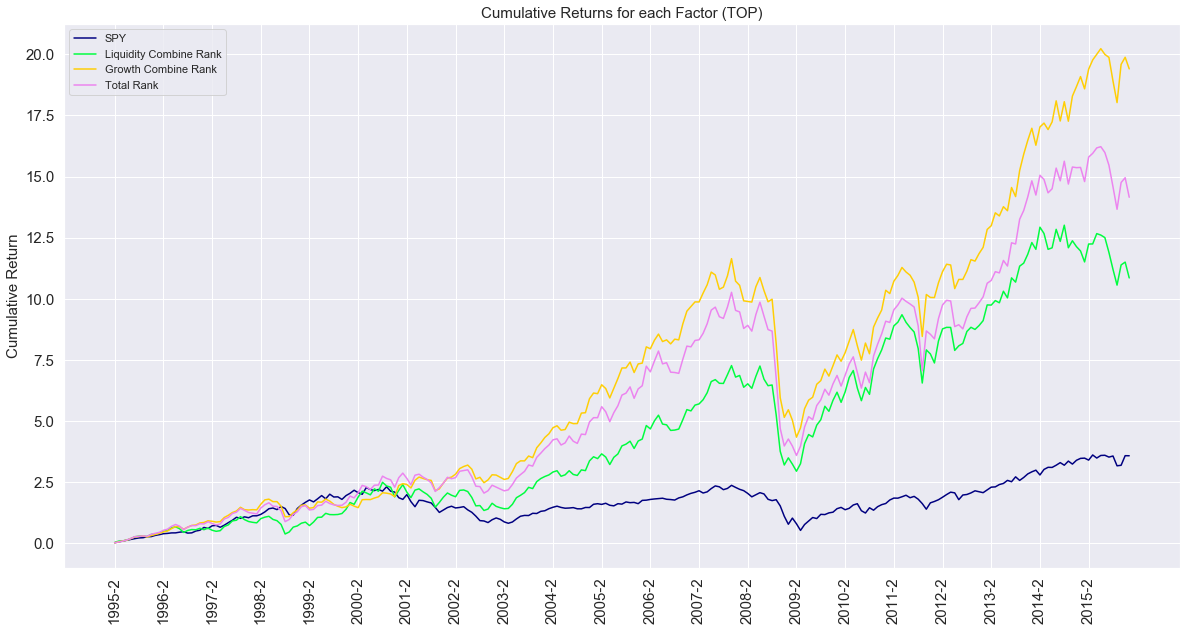

In [32]:
Object2.Plot_Cum_TOP_Return()

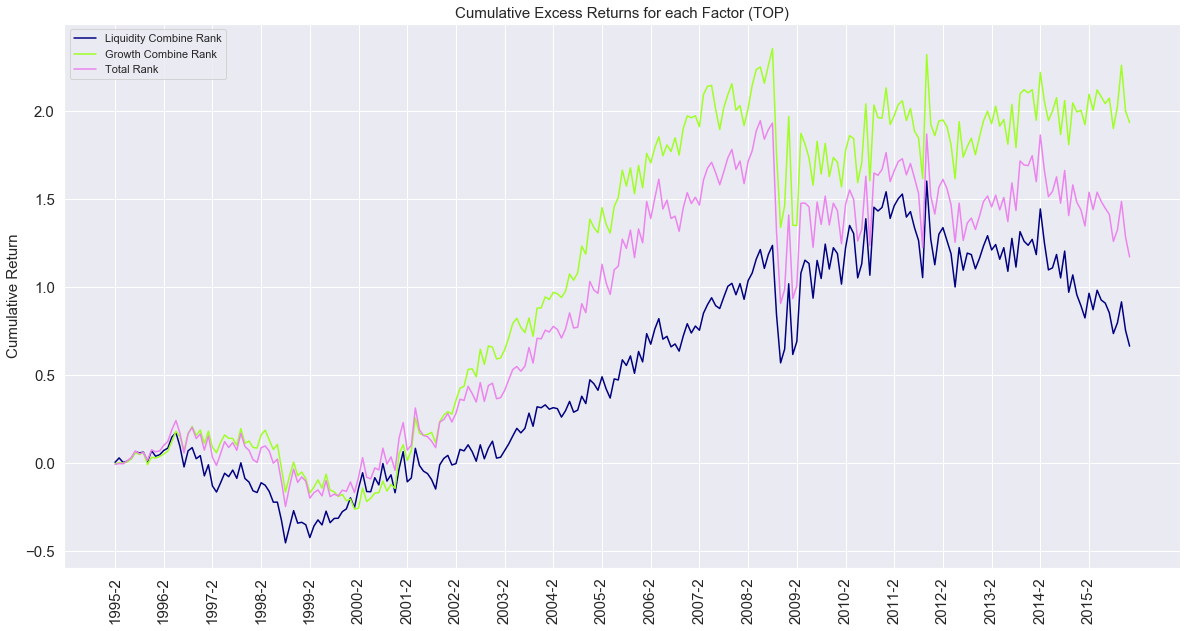

In [33]:
Object2.Plot_Cum_TOP_Excess()

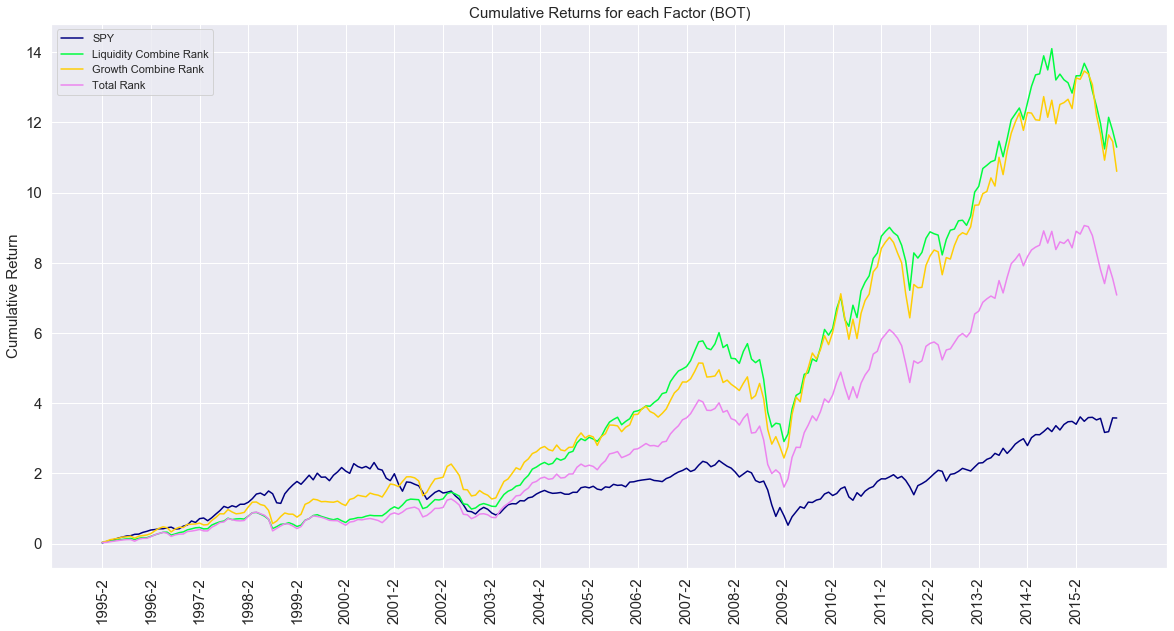

In [34]:
Object2.Plot_Cum_BOT_Return()

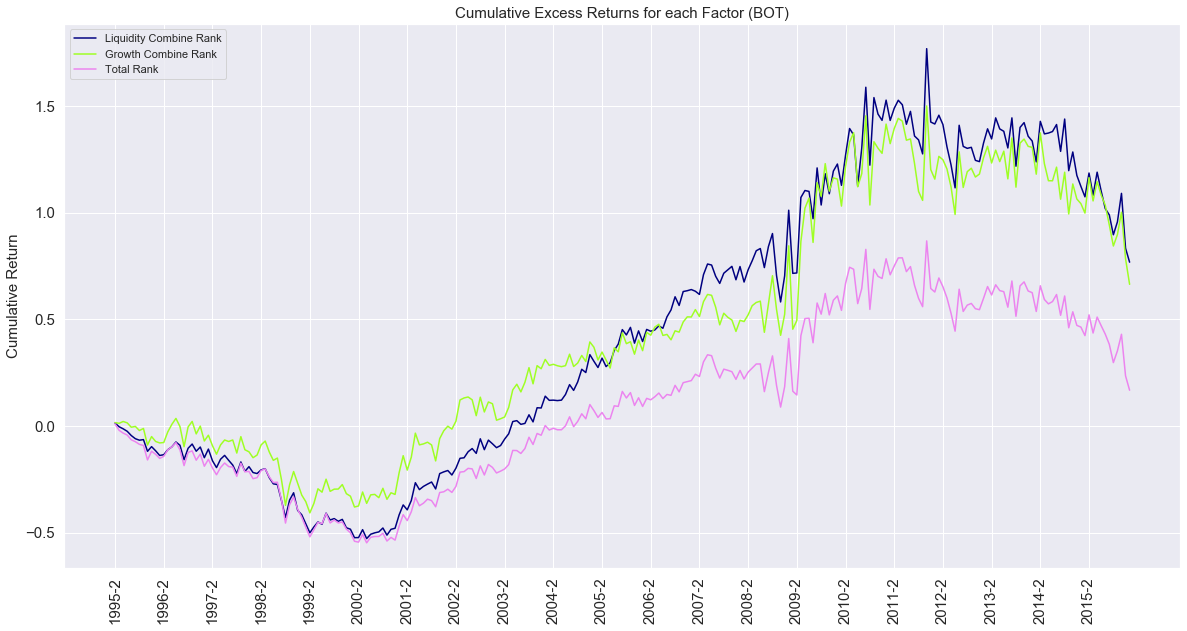

In [35]:
Object2.Plot_Cum_BOT_Excess()

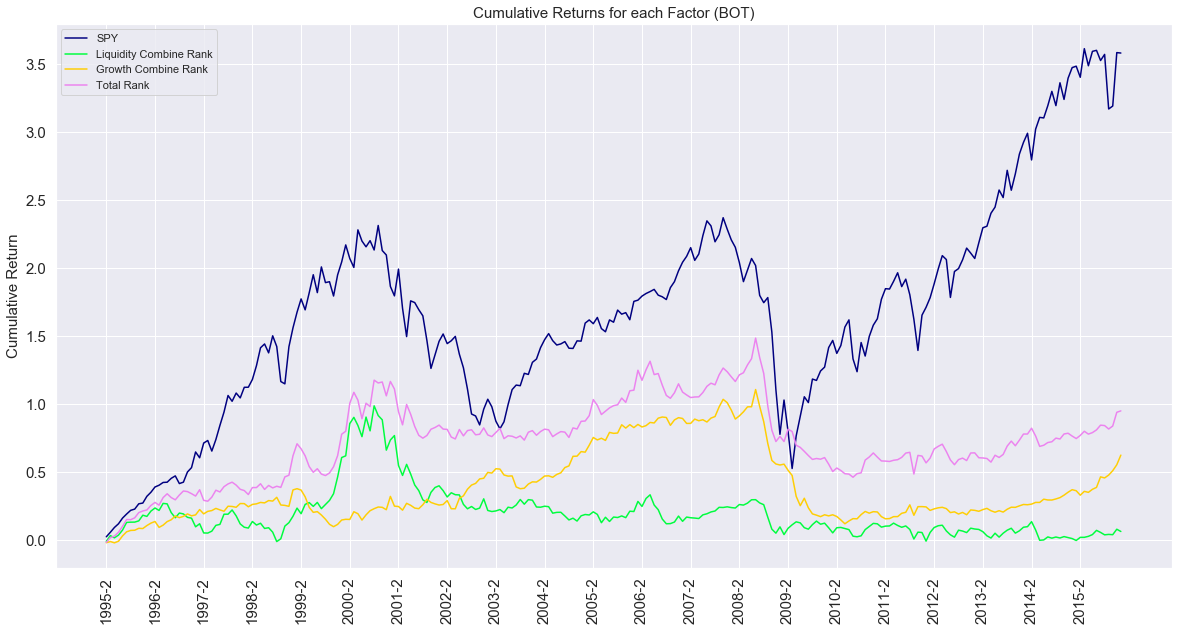

In [36]:
Object2.Plot_Cum_Diff_Return()

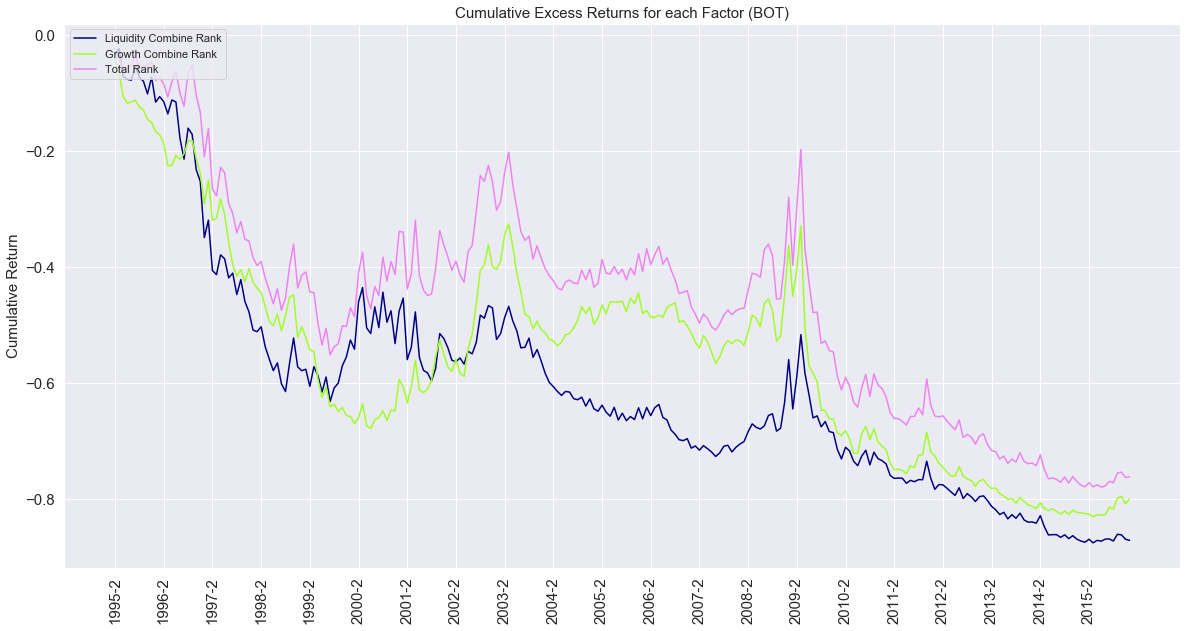

In [37]:
Object2.Plot_Cum_Diff_Excess()

# Calculate Alpha & Beta

In [38]:
# Return_TOP = Object.Returns1
# Return_BOT = Object.Returns2
# Return_Diff = Object.Diffs

# Excess_TOP = Object.Excesses1
# Excess_BOT = Object.Excesses2
# Excess_Diff = Object.Diffs_Excess

# Rm = Object.SPY.iloc[1:].values.ravel()

# Rf = 0.0781 / 12   # 20-Year Risk-Free Rate from Jan. 1995, /12 -> Monthly Return

In [39]:
# class Indicators():
#     def __init__(self, Return_TOP, Return_BOT, Return_Diff, Rm, Rf, Factor_Rank):
#         self.Return_TOP = Return_TOP
#         self.Return_BOT = Return_BOT
#         self.Return_DIF = Return_Diff
# #         self.Excess_TOP = Excess_TOP
# #         self.Excess_BOT = Excess_BOT
# #         self.Excess_Diff = Excess_Diff
#         self.Rm = Rm
#         self.Rf = Rf
# #         self.Date = Date
#         self.Factor_Rank = Factor_Rank
        
#     def Cal_Beta(self):
#         self.Beta_TOP = {}
#         self.Beta_BOT = {}
#         self.Beta_DIF = {}
#         Variance_Rm = np.var(self.Rm)
        
#         for key in self.Factor_Rank:
#             self.Beta_TOP[key] = np.cov(self.Return_TOP[key], self.Rm)[0,1]
#             self.Beta_BOT[key] = np.cov(self.Return_BOT[key], self.Rm)[0,1]
#             self.Beta_DIF[key] = np.cov(self.Return_DIF[key], self.Rm)[0,1]
        
#     def Cal_Alpha(self):        
#         self.Alpha_TOP = {}
#         self.Alpha_BOT = {}
#         self.Alpha_DIF = {}
        
#         for key in self.Factor_Rank:
#             R_TOP = [];  R_BOT = [];  R_DIF = []
#             for i in range(251):
#                 R_TOP.append(self.Return_TOP[key][i] - self.Rf - self.Beta_TOP[key] * (self.Rm[i] - self.Rf))
#                 R_BOT.append(self.Return_BOT[key][i] - self.Rf - self.Beta_BOT[key] * (self.Rm[i] - self.Rf))
#                 R_DIF.append(self.Return_DIF[key][i] - self.Rf - self.Beta_DIF[key] * (self.Rm[i] - self.Rf))
                
#             self.Alpha_TOP[key] = R_TOP
#             self.Alpha_BOT[key] = R_BOT
#             self.Alpha_DIF[key] = R_DIF
            
#     def Summary_Alpha(self):
#         from scipy import stats
#         for key in self.Factor_Rank:  
#             print("============================" + key + "============================")
#             print("Mean of " + key + "'s Alpha (TOP): ", np.mean(self.Alpha_TOP[key]))
#             print("Result of T Test for " + key + "'s Alpha is(TOP): ")
#             print(stats.ttest_1samp(self.Alpha_TOP[key], 0), "\n")
            
#             print("Mean of " + key + "'s Alpha (BOT): ", np.mean(self.Alpha_BOT[key]))
#             print("Result of T Test for " + key + "'s Alpha is(BOT): ")
#             print(stats.ttest_1samp(self.Alpha_BOT[key], 0), "\n")
            
#             print("Mean of " + key + "'s Alpha (DIF): ", np.mean(self.Alpha_DIF[key]))
#             print("Result of T Test for " + key + "'s Alpha is(DIF): ")
#             print(stats.ttest_1samp(self.Alpha_DIF[key], 0), "\n")    
            
        
#         print("============================++++++++++++++============================")

## Single Factors

In [40]:
# Object3 = Indicators(Return_TOP, Return_BOT, Return_Diff, Rm, Rf, Factor_Rank)

In [41]:
# Object3.Cal_Beta()
# Object3.Cal_Alpha()

In [42]:
# Object3.Summary_Alpha()

## Combine Factors

In [43]:
# Return_TOP2 = Object2.Returns1
# Return_BOT2 = Object2.Returns2
# Return_Diff2 = Object2.Diffs

# Rm2 = Object2.SPY.iloc[1:].values.ravel()

# Rf2 = 0.0781 / 12   # 20-Year Risk-Free Rate from Jan. 1995, /12 -> Monthly Return
# Combine_Rank = ['Liquidity Combine Rank', 'Growth Combine Rank', 'Total Rank']

In [44]:
# Object4 = Indicators(Return_TOP2, Return_BOT2, Return_Diff2, Rm2, Rf2, Combine_Rank)
# Object4.Cal_Beta()
# Object4.Cal_Alpha()

In [45]:
# Object4.Summary_Alpha()

# Calculate Max DrawDown

In [46]:
def MaxDrawdown(return_list):
    return_list.insert(0,0)
    a = pd.Series(return_list)
    a += 1
    a = a.cumprod()
    return_list = list(a)
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])
    return (return_list[j] - return_list[i]) / (return_list[j])

In [47]:
# Max_DrawDown_TOP = {}
# Max_DrawDown_BOT = {}
# Max_DrawDown_DIF = {}

# for key in Factor_Rank:
#     Max_DrawDown_TOP[key] = MaxDrawdown(Return_TOP[key])
#     Max_DrawDown_BOT[key] = MaxDrawdown(Return_BOT[key])
#     Max_DrawDown_DIF[key] = MaxDrawdown(Return_Diff[key])

## Long Top

In [48]:
# for key in Factor_Rank:
#     print(Max_DrawDown_TOP[key])

## Long Bottom

In [49]:
# for key in Factor_Rank:
#     print(Max_DrawDown_BOT[key])

## Long Top & Short Bottom

In [50]:
# for key in Factor_Rank:
#     print(Max_DrawDown_DIF[key])

In [51]:
# returns = [1.0, 1.01, 1.05, 1.1, 1.11, 1.07, 1.03, 1.03, 1.01, 1.02]

# max_draw_down = 0
# temp_max_value = 0
# for i in range(1, len(returns)):
#     temp_max_value = max(temp_max_value, returns[i-1])
#     max_draw_down = min(max_draw_down, returns[i]/temp_max_value-1)
#     print(i, temp_max_value, max_draw_down)

In [52]:
# returns = [1.0, 1.01, 1.05, 1.1, 1.11, 1.07, 1.13, 1.03, 1.01, 1.02]

# tmp_max = 0.0 
# max_dd = 0.0

# for i in range(1, len(returns)):
#     tmp_max = max(tmp_max, returns[i-1])
#     max_dd = min(max_dd, returns[i]/tmp_max - 1)
#     print(i, tmp_max, abs(max_dd))